In [2]:
from SpecAugment import spec_augment_pytorch
import numpy as np
import torch
import librosa.display
import random

In [3]:
mel_spectrogram = np.load("../audioData/train_process_mel/00716-3-005-m-24-335-sad-sad-sad.npy")
mel_spectrogram = torch.Tensor([mel_spectrogram]*64)

In [6]:
%%time
spec_augment_pytorch.spec_augment(mel_spectrogram[4].unsqueeze(0))

CPU times: user 21.3 ms, sys: 18.5 ms, total: 39.8 ms
Wall time: 6.87 ms


tensor([[[-29.8867, -19.4721, -20.1508,  ..., -12.6657, -21.7644, -28.3287],
         [-42.2429, -21.4899, -21.3133,  ..., -17.6198, -21.5316, -21.7439],
         [-23.1295, -21.4466, -22.5453,  ..., -21.4243, -21.6229, -20.2691],
         ...,
         [-56.7934, -58.9579, -59.0702,  ..., -60.1270, -61.1168, -62.0487],
         [-58.4937, -57.1383, -56.6848,  ..., -62.2462, -65.4136, -63.1610],
         [-57.5767, -54.8568, -55.1241,  ..., -63.3680, -65.5047, -65.5047]]])

In [4]:
mel_spectrogram.shape

torch.Size([64, 128, 93])

In [11]:
def sa(i_mel):
    return spec_augment_pytorch.spec_augment(i_mel,time_warping_para=80, frequency_masking_para=15,
                 time_masking_para=15, frequency_mask_num=2, time_mask_num=3)

In [5]:
import multiprocessing as mp

In [10]:
pool = mp.Pool(10)

In [9]:
B = mel_spectrogram.shape[0]
i_mels = []
for i in range(B):
    i_mel = mel_spectrogram[i,:,:].unsqueeze(0)
    i_mels.append(i_mel)
warped = pool.map(sa,i_mels)

/workspace/ML_qia2019-1/SpecAugment/sparse_image_warp_pytorch.py:317: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(queries - floor, dtype=grid_type)
/workspace/ML_qia2019-1/SpecAugment/sparse_image_warp_pytorch.py:317: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(queries - floor, dtype=grid_type)
/workspace/ML_qia2019-1/SpecAugment/sparse_image_warp_pytorch.py:317: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(queries - floor, dtype=grid_type)
/workspace/ML_qia2019-1/SpecAug

KeyboardInterrupt: 

In [7]:
%%time
B = mel_spectrogram.shape[0]
warped = []
for i in range(B):
    i_mel = mel_spectrogram[i,:,:].unsqueeze(0)
#     print(i_mel.shape)
    warped.append(spec_augment_pytorch.spec_augment(i_mel,time_warping_para=80, frequency_masking_para=15,
                 time_masking_para=15, frequency_mask_num=2, time_mask_num=3))
warped_mel = torch.cat(warped)

CPU times: user 1.86 s, sys: 0 ns, total: 1.86 s
Wall time: 218 ms


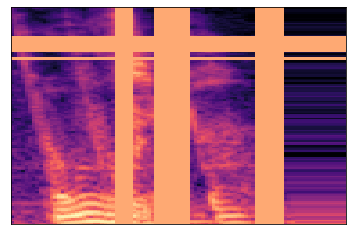

In [27]:
librosa.display.specshow(warped_mel[0].cpu().detach().numpy())

In [3]:
warped_masked_spectrogram = spec_augment_pytorch.spec_augment(mel_spectrogram = mel_spectrogram)

RuntimeError: shape '[64, 128, 93, 2]' is invalid for input of size 23808

In [ ]:
librosa.display.specshow(warped_masked_spectrogram.cpu().detach().numpy()[0])

In [ ]:
librosa.display.specshow(mel_spectrogram.cpu().detach().numpy()[0])

In [3]:
def sparse_image_warp(img_tensor,
                      source_control_point_locations,
                      dest_control_point_locations,
                      interpolation_order=2,
                      regularization_weight=0.0,
                      num_boundaries_points=0):
    device = img_tensor.device
    control_point_flows = (dest_control_point_locations - source_control_point_locations)   
    
#     clamp_boundaries = num_boundary_points > 0
#     boundary_points_per_edge = num_boundary_points - 1
    batch_size, image_height, image_width = img_tensor.shape
    flattened_grid_locations = get_flat_grid_locations(image_height, image_width, device)

    # IGNORED FOR OUR BASIC VERSION...
#     flattened_grid_locations = constant_op.constant(
#         _expand_to_minibatch(flattened_grid_locations, batch_size), image.dtype)

#     if clamp_boundaries:
#       (dest_control_point_locations,
#        control_point_flows) = _add_zero_flow_controls_at_boundary(
#            dest_control_point_locations, control_point_flows, image_height,
#            image_width, boundary_points_per_edge)

    flattened_flows = interpolate_spline(
        dest_control_point_locations,
        control_point_flows,
        flattened_grid_locations,
        interpolation_order,
        regularization_weight)

    dense_flows = create_dense_flows(flattened_flows, batch_size, image_height, image_width)

    warped_image = dense_image_warp(img_tensor, dense_flows)

    return warped_image, dense_flows


In [4]:

#Export
def get_grid_locations(image_height, image_width, device):
    y_range = torch.linspace(0, image_height - 1, image_height, device=device)
    x_range = torch.linspace(0, image_width - 1, image_width, device=device)
    y_grid, x_grid = torch.meshgrid(y_range, x_range)
    return torch.stack((y_grid, x_grid), -1)

In [5]:
def flatten_grid_locations(grid_locations, image_height, image_width):
    return torch.reshape(grid_locations, [image_height * image_width, 2])

In [6]:
def get_flat_grid_locations(image_height, image_width, device):
    y_range = torch.linspace(0, image_height - 1, image_height, device=device)
    x_range = torch.linspace(0, image_width - 1, image_width, device=device)
    y_grid, x_grid = torch.meshgrid(y_range, x_range)
    return torch.stack((y_grid, x_grid), -1).reshape([image_height * image_width, 2])

In [7]:
def create_dense_flows(flattened_flows, batch_size, image_height, image_width):
    # possibly .view
    return torch.reshape(flattened_flows, [batch_size, image_height, image_width, 2])

In [8]:
def interpolate_spline(train_points, train_values, query_points, order, regularization_weight=0.0,):
    # First, fit the spline to the observed data.
    w, v = solve_interpolation(train_points, train_values, order, regularization_weight)
    # Then, evaluate the spline at the query locations.
    query_values = apply_interpolation(query_points, train_points, w, v, order)

    return query_values

In [9]:
def solve_interpolation(train_points, train_values, order, regularization_weight):
    device = train_points.device
    b, n, d = train_points.shape
    k = train_values.shape[-1]

    # First, rename variables so that the notation (c, f, w, v, A, B, etc.)
    # follows https://en.wikipedia.org/wiki/Polyharmonic_spline.
    # To account for python style guidelines we use
    # matrix_a for A and matrix_b for B.
    
    c = train_points
    f = train_values.float()
    
    matrix_a = phi(cross_squared_distance_matrix(c,c), order).unsqueeze(0)  # [b, n, n]
#     if regularization_weight > 0:
#         batch_identity_matrix = array_ops.expand_dims(
#           linalg_ops.eye(n, dtype=c.dtype), 0)
#         matrix_a += regularization_weight * batch_identity_matrix

    # Append ones to the feature values for the bias term in the linear model.
    ones = torch.ones(1, dtype=train_points.dtype, device=device).view([-1, 1, 1])
    matrix_b = torch.cat((c, ones), 2).float()  # [b, n, d + 1]

    # [b, n + d + 1, n]
    left_block = torch.cat((matrix_a, torch.transpose(matrix_b, 2, 1)), 1)

    num_b_cols = matrix_b.shape[2]  # d + 1

    # In Tensorflow, zeros are used here. Pytorch solve fails with zeros for some reason we don't understand.
    # So instead we use very tiny randn values (variance of one, zero mean) on one side of our multiplication.
    lhs_zeros = torch.randn((b, num_b_cols, num_b_cols), device=device) / 1e10
    right_block = torch.cat((matrix_b, lhs_zeros),
                                   1)  # [b, n + d + 1, d + 1]
    lhs = torch.cat((left_block, right_block),
                           2)  # [b, n + d + 1, n + d + 1]

    rhs_zeros = torch.zeros((b, d + 1, k), dtype=train_points.dtype, device=device).float()
    rhs = torch.cat((f, rhs_zeros), 1)  # [b, n + d + 1, k]

    # Then, solve the linear system and unpack the results.
    X, LU = torch.solve(rhs, lhs)
    w = X[:, :n, :]
    v = X[:, n:, :]

    return w, v

In [10]:
def cross_squared_distance_matrix(x, y):
    """Pairwise squared distance between two (batch) matrices' rows (2nd dim).
        Computes the pairwise distances between rows of x and rows of y
        Args:
        x: [batch_size, n, d] float `Tensor`
        y: [batch_size, m, d] float `Tensor`
        Returns:
        squared_dists: [batch_size, n, m] float `Tensor`, where
        squared_dists[b,i,j] = ||x[b,i,:] - y[b,j,:]||^2
    """
    x_norm_squared = torch.sum(torch.mul(x, x))
    y_norm_squared = torch.sum(torch.mul(y, y))

    x_y_transpose = torch.matmul(x.squeeze(0), y.squeeze(0).transpose(0,1))
    
    # squared_dists[b,i,j] = ||x_bi - y_bj||^2 = x_bi'x_bi- 2x_bi'x_bj + x_bj'x_bj
    squared_dists = x_norm_squared - 2 * x_y_transpose + y_norm_squared

    return squared_dists.float()

In [11]:
def phi(r, order):
    """Coordinate-wise nonlinearity used to define the order of the interpolation.
    See https://en.wikipedia.org/wiki/Polyharmonic_spline for the definition.
    Args:
    r: input op
    order: interpolation order
    Returns:
    phi_k evaluated coordinate-wise on r, for k = r
    """
    EPSILON=torch.tensor(1e-10, device=r.device)
    # using EPSILON prevents log(0), sqrt0), etc.
    # sqrt(0) is well-defined, but its gradient is not
    if order == 1:
        r = torch.max(r, EPSILON)
        r = torch.sqrt(r)
        return r
    elif order == 2:
        return 0.5 * r * torch.log(torch.max(r, EPSILON))
    elif order == 4:
        return 0.5 * torch.square(r) * torch.log(torch.max(r, EPSILON))
    elif order % 2 == 0:
        r = torch.max(r, EPSILON)
        return 0.5 * torch.pow(r, 0.5 * order) * torch.log(r)
    else:
        r = torch.max(r, EPSILON)
        return torch.pow(r, 0.5 * order)

In [12]:
def apply_interpolation(query_points, train_points, w, v, order):
    """Apply polyharmonic interpolation model to data.
    Given coefficients w and v for the interpolation model, we evaluate
    interpolated function values at query_points.
    Args:
    query_points: `[b, m, d]` x values to evaluate the interpolation at
    train_points: `[b, n, d]` x values that act as the interpolation centers
                    ( the c variables in the wikipedia article)
    w: `[b, n, k]` weights on each interpolation center
    v: `[b, d, k]` weights on each input dimension
    order: order of the interpolation
    Returns:
    Polyharmonic interpolation evaluated at points defined in query_points.
    """
    query_points = query_points.unsqueeze(0)
    # First, compute the contribution from the rbf term.
    pairwise_dists = cross_squared_distance_matrix(query_points.float(), train_points.float())
    phi_pairwise_dists = phi(pairwise_dists, order)

    rbf_term = torch.matmul(phi_pairwise_dists, w)

    # Then, compute the contribution from the linear term.
    # Pad query_points with ones, for the bias term in the linear model.
    ones = torch.ones_like(query_points[..., :1])
    query_points_pad = torch.cat((
      query_points,
      ones
    ), 2).float()
    linear_term = torch.matmul(query_points_pad, v)

    return rbf_term + linear_term

In [13]:
#Export
def dense_image_warp(image, flow):
    """Image warping using per-pixel flow vectors.
    Apply a non-linear warp to the image, where the warp is specified by a dense
    flow field of offset vectors that define the correspondences of pixel values
    in the output image back to locations in the  source image. Specifically, the
    pixel value at output[b, j, i, c] is
    images[b, j - flow[b, j, i, 0], i - flow[b, j, i, 1], c].
    The locations specified by this formula do not necessarily map to an int
    index. Therefore, the pixel value is obtained by bilinear
    interpolation of the 4 nearest pixels around
    (b, j - flow[b, j, i, 0], i - flow[b, j, i, 1]). For locations outside
    of the image, we use the nearest pixel values at the image boundary.
    Args:
    image: 4-D float `Tensor` with shape `[batch, height, width, channels]`.
    flow: A 4-D float `Tensor` with shape `[batch, height, width, 2]`.
    name: A name for the operation (optional).
    Note that image and flow can be of type tf.half, tf.float32, or tf.float64,
    and do not necessarily have to be the same type.
    Returns:
    A 4-D float `Tensor` with shape`[batch, height, width, channels]`
    and same type as input image.
    Raises:
    ValueError: if height < 2 or width < 2 or the inputs have the wrong number
    of dimensions.
    """
    image = image.unsqueeze(3) # add a single channel dimension to image tensor
    batch_size, height, width, channels = image.shape
    device = image.device

    # The flow is defined on the image grid. Turn the flow into a list of query
    # points in the grid space.
    grid_x, grid_y = torch.meshgrid(
        torch.arange(width, device=device), torch.arange(height, device=device))
    
    stacked_grid = torch.stack((grid_y, grid_x), dim=2).float()
    
    batched_grid = stacked_grid.unsqueeze(-1).permute(3, 1, 0, 2)
    
    query_points_on_grid = batched_grid - flow
    query_points_flattened = torch.reshape(query_points_on_grid,
                                               [batch_size, height * width, 2])
    # Compute values at the query points, then reshape the result back to the
    # image grid.
    interpolated = interpolate_bilinear(image, query_points_flattened)
    interpolated = torch.reshape(interpolated,
                                     [batch_size, height, width, channels])
    return interpolated

In [14]:

#Export
def interpolate_bilinear(grid,
                         query_points,
                         name='interpolate_bilinear',
                         indexing='ij'):
    """Similar to Matlab's interp2 function.
    Finds values for query points on a grid using bilinear interpolation.
    Args:
    grid: a 4-D float `Tensor` of shape `[batch, height, width, channels]`.
    query_points: a 3-D float `Tensor` of N points with shape `[batch, N, 2]`.
    name: a name for the operation (optional).
    indexing: whether the query points are specified as row and column (ij),
      or Cartesian coordinates (xy).
    Returns:
    values: a 3-D `Tensor` with shape `[batch, N, channels]`
    Raises:
    ValueError: if the indexing mode is invalid, or if the shape of the inputs
      invalid.
    """
    if indexing != 'ij' and indexing != 'xy':
        raise ValueError('Indexing mode must be \'ij\' or \'xy\'')


    shape = grid.shape
    if len(shape) != 4:
        msg = 'Grid must be 4 dimensional. Received size: '
        raise ValueError(msg + str(grid.shape))

    batch_size, height, width, channels = grid.shape

    shape = [batch_size, height, width, channels]
    query_type = query_points.dtype
    grid_type = grid.dtype
    grid_device = grid.device

    num_queries = query_points.shape[1]

    alphas = []
    floors = []
    ceils = []
    index_order = [0, 1] if indexing == 'ij' else [1, 0]
    unstacked_query_points = query_points.unbind(2)

    for dim in index_order:
        queries = unstacked_query_points[dim]

        size_in_indexing_dimension = shape[dim + 1]

        # max_floor is size_in_indexing_dimension - 2 so that max_floor + 1
        # is still a valid index into the grid.
        max_floor = torch.tensor(size_in_indexing_dimension - 2, dtype=query_type, device=grid_device)
        min_floor = torch.tensor(0.0, dtype=query_type, device=grid_device)
        maxx = torch.max(min_floor, torch.floor(queries))
        floor = torch.min(maxx, max_floor)
        int_floor = floor.long()
        floors.append(int_floor)
        ceil = int_floor + 1
        ceils.append(ceil)

        # alpha has the same type as the grid, as we will directly use alpha
        # when taking linear combinations of pixel values from the image.
        
        
        alpha = torch.tensor((queries - floor), dtype=grid_type, device=grid_device)
        min_alpha = torch.tensor(0.0, dtype=grid_type, device=grid_device)
        max_alpha = torch.tensor(1.0, dtype=grid_type, device=grid_device)
        alpha = torch.min(torch.max(min_alpha, alpha), max_alpha)

        # Expand alpha to [b, n, 1] so we can use broadcasting
        # (since the alpha values don't depend on the channel).
        alpha = torch.unsqueeze(alpha, 2)
        alphas.append(alpha)

    flattened_grid = torch.reshape(
      grid, [batch_size * height * width, channels])
    batch_offsets = torch.reshape(
      torch.arange(batch_size, device=grid_device) * height * width, [batch_size, 1])

    # This wraps array_ops.gather. We reshape the image data such that the
    # batch, y, and x coordinates are pulled into the first dimension.
    # Then we gather. Finally, we reshape the output back. It's possible this
    # code would be made simpler by using array_ops.gather_nd.
    def gather(y_coords, x_coords, name):
        linear_coordinates = batch_offsets + y_coords * width + x_coords
        gathered_values = torch.gather(flattened_grid.t(), 1, linear_coordinates)
        return torch.reshape(gathered_values,
                                 [batch_size, num_queries, channels])

    # grab the pixel values in the 4 corners around each query point
    top_left = gather(floors[0], floors[1], 'top_left')
    top_right = gather(floors[0], ceils[1], 'top_right')
    bottom_left = gather(ceils[0], floors[1], 'bottom_left')
    bottom_right = gather(ceils[0], ceils[1], 'bottom_right')

    interp_top = alphas[1] * (top_right - top_left) + top_left
    interp_bottom = alphas[1] * (bottom_right - bottom_left) + bottom_left
    interp = alphas[0] * (interp_bottom - interp_top) + interp_top

    return interp

In [15]:
mel_spectrogram = np.load("../audioData/train_process_mel/00716-3-005-m-24-335-sad-sad-sad.npy")
mel_spectrogram = torch.Tensor([mel_spectrogram]*64)

In [16]:
def time_warp(spec, W=5):
    num_rows = spec.shape[1] ##F
    spec_len = spec.shape[2] ##T

    y = num_rows // 2
    horizontal_line_at_ctr = spec[0][y]
    # assert len(horizontal_line_at_ctr) == spec_len

    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len-W)]
    # assert isinstance(point_to_warp, torch.Tensor)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts = torch.tensor([[[y, point_to_warp]]])
    dest_pts = torch.tensor([[[y, point_to_warp + dist_to_warp]]])
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3)

In [17]:
def spec_augment(mel_spectrogram, time_warping_para=80, frequency_masking_para=27,
                 time_masking_para=100, frequency_mask_num=1, time_mask_num=1):
    """Spec augmentation Calculation Function.
    'SpecAugment' have 3 steps for audio data augmentation.
    first step is time warping using Tensorflow's image_sparse_warp function.
    Second step is frequency masking, last step is time masking.
    # Arguments:
      mel_spectrogram(numpy array): audio file path of you want to warping and masking.
      time_warping_para(float): Augmentation parameter, "time warp parameter W".
        If none, default = 80 for LibriSpeech.
      frequency_masking_para(float): Augmentation parameter, "frequency mask parameter F"
        If none, default = 100 for LibriSpeech.
      time_masking_para(float): Augmentation parameter, "time mask parameter T"
        If none, default = 27 for LibriSpeech.
      frequency_mask_num(float): number of frequency masking lines, "m_F".
        If none, default = 1 for LibriSpeech.
      time_mask_num(float): number of time masking lines, "m_T".
        If none, default = 1 for LibriSpeech.
    # Returns
      mel_spectrogram(numpy array): warped and masked mel spectrogram.
    """
    v = mel_spectrogram.shape[1]
    tau = mel_spectrogram.shape[2]

    # Step 1 : Time warping
    warped_mel_spectrogram = time_warp(mel_spectrogram)

    # Step 2 : Frequency masking
    for i in range(frequency_mask_num):
        f = np.random.uniform(low=0.0, high=frequency_masking_para)
        f = int(f)
        f0 = random.randint(0, v-f)
        warped_mel_spectrogram[:, f0:f0+f, :] = 0

    # Step 3 : Time masking
    for i in range(time_mask_num):
        t = np.random.uniform(low=0.0, high=time_masking_para)
        t = int(t)
        t0 = random.randint(0, tau-t)
        warped_mel_spectrogram[:, :, t0:t0+t] = 0

    return warped_mel_spectrogram

In [20]:
spec_augment(mel_spectrogram = mel_spectrogram)

RuntimeError: shape '[64, 128, 93, 2]' is invalid for input of size 23808